In [1]:
import librosa.display
import matplotlib.pyplot as plt
import pretty_midi
import mir_eval.display
import numpy as np

from utils import detect_monophony,is_fourfour,plot_piano_roll

In [ ]:
# TODO:
# 1- write a function which gives piano roll and audio of given midi prediction
# 2- remove non-4/4 time signatures, set tempo=120, quantize to 16 notes per bar

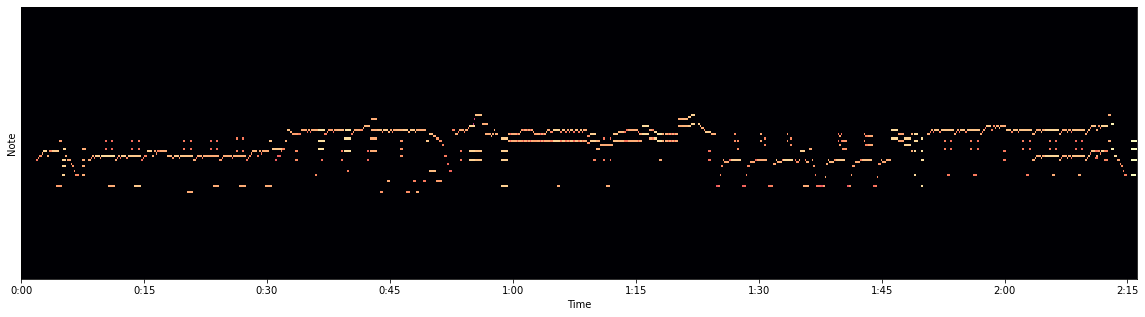

In [220]:
midi_data = pretty_midi.PrettyMIDI('../data/midi_dump/3rdman.mid')
plt.figure(figsize=(20, 5))
plot_piano_roll(midi_data.instruments[0], 0,127)

In [91]:
TEMPO = 120.  # 1 sec = 2 beats
SIXTEENTH_NOTE_BEATS = 0.25  # 1 16th note = 0.25 beats
SIXTEENTH_NOTE_LEN = SIXTEENTH_NOTE_BEATS / (TEMPO / 60.)  # 1 16th note = 0.125 sec
ONE_BAR_LEN = SIXTEENTH_NOTE_LEN * 16  # 16 16th notes = 1 bar = 2 sec
EIGHT_BAR_LEN = ONE_BAR_LEN * 8  # 16-bar = 32 sec


In [207]:
# given single note with start and end time, finds it bins
def find_note_bins(note,bin_limits):
    temp_start,temp_end = note.start, note.end
    start_bin = -1
    end_bin = -1
    start_time = bin_limits[0]
    for i in range(len(bin_limits)-1):
        if temp_start >= (i * SIXTEENTH_NOTE_LEN)+start_time and temp_start < ((i+1) * SIXTEENTH_NOTE_LEN) + start_time:
            start_bin = i
        if temp_end >= (i * SIXTEENTH_NOTE_LEN)+start_time and temp_end < ((i+1) * SIXTEENTH_NOTE_LEN)+ start_time:
            end_bin = i

    return start_bin,end_bin-1

# given a midi note sequence, and bin_limits
# returns None if sequence is non-monophonic
# returns event-note pairs if monophonic
def is_eight_bar_monophonic(temp_notes,bin_limits,bin_idx):
    event_per_bar = 16
    total_bars = 8
    event2note = dict.fromkeys(np.arange(start=bin_idx*event_per_bar*total_bars,stop=(bin_idx+1)*event_per_bar*total_bars-2))
    
    for temp_note in temp_notes:
        if temp_note.start >= bin_limits[0] and temp_note.end <= bin_limits[-1]:
            start_bin,end_bin = find_note_bins(temp_note,bin_limits)

            start_bin = start_bin + bin_idx*event_per_bar*total_bars
            end_bin = end_bin + bin_idx*event_per_bar*total_bars
            
            temp_bin = start_bin
            while temp_bin <= end_bin:
                if event2note[temp_bin] is None:
                    event2note[temp_bin] = temp_note.pitch
                    temp_bin += 1
                else:
                    return

    return event2note

In [223]:
temp_notes = midi_data.instruments[0].notes

monop_count = 0
for bin_idx in range(int(np.floor(midi_data.get_end_time() / EIGHT_BAR_LEN))):
    bin_limits = np.arange(start=(bin_idx)*EIGHT_BAR_LEN,stop=(bin_idx+1)*EIGHT_BAR_LEN,step=SIXTEENTH_NOTE_LEN)
    
    if not is_eight_bar_monophonic(temp_notes,bin_limits,bin_idx) is None:
        monop_count += 1

print(monop_count)



0


In [170]:
midi_data.get_end_time() 

155.53701

In [56]:
import glob
#midi_list = glob.glob("../data/maestro-v3.0.0/*/*.midi")
midi_list = glob.glob("../data/midi_dump/*.mid")

total_8bar_count = 0
total_monop_count = 0
for midi_file in midi_list:
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    if is_fourfour(midi_data):  # eleminate non-4/4 midi files
        print_str,monop_count = detect_monophony(midi_data)
        if monop_count >0 :
            total_monop_count += monop_count
            total_8bar_count += np.floor(midi_data.get_end_time()/16.0)
    
print(total_monop_count,total_8bar_count)

163 1277.0
